# <center>Make NIRCam Simple Improved Reference Subtraction (SIRS) Calibration Files</center>

<center><center>Bernard J. Rauscher<br>
<em>Observational Cosmology Laboratory, NASA Goddard Space Flight Center, Greenbelt, MD, 21784, USA</em><br>
Bernard.J.Rauscher@nasa.gov</center></center>

## Abstract

This notebook shows how to compute the Simple Improved Reference Subtraction (SIRS)$^1$ calibration files for JWST NIRCam. SIRS provides statistically optimal reference correction if: (1) correlated read noise is strongly dominated by $1/f$ noise, (2) the reference pixel border is the only reference information that is available, and (3) the left and right reference columns are robustly averaged into 2048 two element vectors. Mathematically, SIRS is superior to smoothing the reference columns any other way (i.e. rolling median or Gauss smoothing). SIRS provides reference correction that is intermediate between the current NIRCam Pipeline and NIRSpec's Improved Reference Sampling and Subtraction (IRS$^2$) that uses a speciallized clocking pattern to interleave additional reference information.$^2$

## 1 INTRODUCTION

We developed SIRS for Nancy Grace Roman Space Telescope (Roman) ground test data in about 2000. At the time, Roman planned to follow NIRCam's example and downlink only co-averaged groups of data. When Roman testing in the Goddard Detector Characterization Laboratory (DCL) revealed undesirably high $1/f$ noise, we developed SIRS as a mitigation that was consistent with NIRCam-like plans. SIRS is therefore directly applicable to NIRCam as well.

Fortunately, the SIRS study convinced the Roman Project to downlink the reference output as an additional mitigation. Roman will not use SIRS on orbit. Instead, it will use Improved Roman Reference Correction (IRRC). Because NIRCam does not downlink the reference output, SIRS is the best that can be done for NIRCam without making major changes to how the instrument is operated.

## 2 PREPROCESSING

In the JWST Pipeline, SIRS takes the place of reference correction using side reference pixels. You should apply all pipeline steps up through reference correction. For the reference correction step: (1) do not apply the alternating columns noise correction and (2) do not apply the reference columns correction.

## 3 TUTORIAL

### 3.1 Preliminaries

This document is an executable Jupyter notebook. This is Julia.

In [15]:
# Standard packages
using Revise, Glob, FITSIO, HDF5, Plots, FFTW

# Load SIRS
using SIRS

# Definitions. I am working on the National Center for Climate Simulation (NCCS)
# high performance Prism cluster.
prog_id = "01453"                         # The input data are from this Program ID
datdir = "/lscratch/brausche/NRCA"        # Stage data to Prism's high speed disks
outdir = "/explore/nobackup/people/brausche"*
                "/data/JWST/Library/SIRS" # Write results here
nint = 2                                  # Number of integrations per exposure
nframe = 150                              # This many frames per integration
nz = 30                                   # Work in "chunks" of this many frames to fit in GPU RAM

# Vectors of all SWIR NIRCam sensor chip systems (SCS)
nrca = ["nrca1", "nrca2", "nrca3", "nrca4", "nrcalong"]
nrcb = ["nrcb1", "nrcb2", "nrcb3", "nrcb4", "nrcblong"]

# The flight data have many cosmic rays. Instantiate the
# cosmic ray fixer.
F = CRFix(nframe);

### 3.2 Compute NRCA Calibration File

Compute frequencies and frequency dependent weights for NRCA.

In [2]:
f = []
γ = []
ζ = []
ps_𝓵 = []
ps_𝓻 = []
ps_𝓷 = []
for scs in nrca
    
    # STUB
    if scs != "nrca1"; continue; end
   
    # Display status
    println("Processing SCS ", scs)
    
    # Get input files
    files = glob("*"*scs*"*.fits", datdir)
    
    # Do it
    f, _γ, _ζ, _ps_𝓵, _ps_𝓻, _ps_𝓷 = nircam_sirs_solve(F, nz, files)
    push!(γ, _γ)
    push!(ζ, _ζ)  
    push!(ps_𝓵, _ps_𝓵)
    push!(ps_𝓻, _ps_𝓻)
    push!(ps_𝓷, _ps_𝓷)
    
end

# Save
# SIRS.h5write(prog_id, Float32.(f), γ, ζ, nrca, outdir*"/20240416_sirs_nircam_nrca.h5")

Processing SCS nrca1
processing jw01453011001_05201_00001_nrca1_refpixstep.fits integration 1
processing jw01453011001_05201_00001_nrca1_refpixstep.fits integration 2
processing jw01453015001_03201_00001_nrca1_refpixstep.fits integration 1
processing jw01453015001_03201_00001_nrca1_refpixstep.fits integration 2
processing jw01453017001_02201_00001_nrca1_refpixstep.fits integration 1
processing jw01453017001_02201_00001_nrca1_refpixstep.fits integration 2
processing jw01453019001_03301_00001_nrca1_refpixstep.fits integration 1
processing jw01453019001_03301_00001_nrca1_refpixstep.fits integration 2


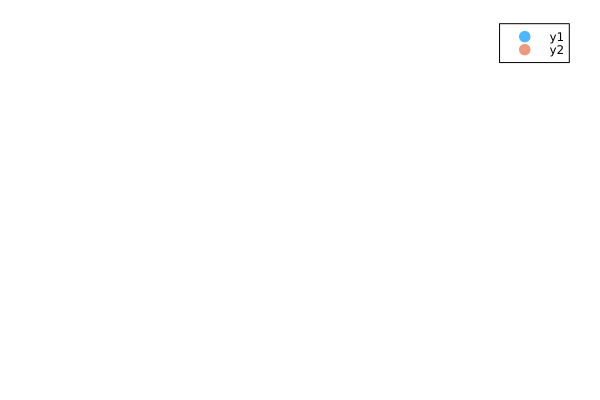

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -1.217926 found at series index 2 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: Invalid negative or zero value -1.217926 found at series index 2 for log10 based yscale
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/8mrSm/src/ticks.jl:194
┌ 

In [35]:
x = rfftfreq(2048, 1/(524*10.e-6)) # Frequency
r = (ps_𝓵[1] + ps_𝓻[1]) / 2 # Reference pixels
scatter(x[2:end], r[2:end].-36, xaxis=:log10, yaxis=:log10, ma=.7, ms=2, msw=0)
scatter!(x[2:end], ps_𝓷[1][2:end,1], xaxis=:log10, yaxis=:log10, ma=.7, ms=2, msw=0)

In [27]:
r

1-element Vector{Vector{Float32}}:
 [278.02637, 73.859566, 34.782074, 20.676182, 14.315474, 10.556768, 8.637035, 6.8784966, 6.04978, 10.971113  …  0.08608031, 0.083141446, 0.0836622, 0.08166483, 0.0860748, 0.0857458, 0.084568955, 0.081973575, 0.08662473, 0.08391735]

### 3.3 Compute NRCB Calibration File

Compute frequencies and frequency dependent weights for NRCB.

## Acknowledgments

This work was supported by the James Webb Space Telescope and Nancy Grace Roman Space Telescope Projects. Resources supporting this work were provided by the NASA High-End Computing (HEC) Program through the NASA Center for Climate Simulation (NCCS) at Goddard Space Flight Center.

## Bibliography
1. Rauscher, B. J., Fixsen, D. J. & Mosby, G. *Simple improved reference subtraction for H4RG, H2RG, and H1RG near-infrared array detectors.* JATIS, Syst. 8, 28002 (2022).
2. Rauscher, B. J. *et al. Improved Reference Sampling and Subtraction: A Technique for Reducing the Read Noise of Near-infrared Detector Systems.* PASP 129, 105003 (2017).

In [3]:
using Revise, CUDA

In [4]:
a = CuArray(randn(5))
b = CuArray(randn(7))

7-element CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}:
 -0.7279494833983545
 -0.2791054591299061
 -1.2717513395181956
 -0.08065091021634176
  0.6243268434823025
  0.3655794697965864
  0.613831512176685